---
# Every classifier feature reduced, dim reduced
---

In [127]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from confusion_matrix import confusion_matrix
from sklearn.metrics import confusion_matrix as cf

"""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})
"""

'\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "cmr"\n})\n'

In [128]:
config = {
    "standardize" : True,
    "lda-reduce" : 4,
    "classifier" : "lda",
    "keep_features" : 10,
    "drop_8_18" : False
}

In [129]:
# Load data sets
trn_sel =  pd.read_csv(f"../TrainingData/neodata/fault_all_10.csv")
trn_data = pd.read_csv(f"../TrainingData/neodata/soltani_14d_nonoise_1200.csv")
vld_data = pd.read_csv(f"../ValidationData/neodata/soltani_14d_nonoise_1200.csv")
tst_data = pd.read_csv(f"../TestData/neodata/soltani_14d_nonoise_100.csv")

if config["drop_8_18"]:
    trn_sel = [ (trn_sel['target'] != 8) & (trn_sel['target'] != 18) ]
    trn_data = [ (trn_data['target'] != 8) & (trn_data['target'] != 18) ]
    vld_data = [ (vld_data['target'] != 8) & (vld_data['target'] != 18) ]
    tst_data = [ (tst_data['target'] != 8) & (tst_data['target'] != 18) ]


# Separate into data and targets
y_sel = trn_sel.pop('target')
X_sel = trn_sel

y_trn = trn_data.pop('target')
X_trn = trn_data#.assign(single=np.ones((len(y_trn),)))

y_vld = vld_data.pop('target')
X_vld = vld_data#.assign(single=np.ones((len(y_vld),)))

y_tst = tst_data.pop('target')
X_tst = tst_data#.assign(single=np.ones((len(y_tst),)))

## Standardize data (z-norm)

In [130]:

if config["standardize"]:
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    
    cols = X_trn.columns

    X_trn_std = standardizer.fit_transform(X_trn)
    X_vld_std = standardizer.transform(X_vld)
    X_tst_std = standardizer.transform(X_tst)
    X_sel_std = standardizer.transform(X_sel)

    X_trn_std = pd.DataFrame(X_trn_std,columns = cols)
    X_vld_std = pd.DataFrame(X_vld_std,columns = cols)
    X_tst_std = pd.DataFrame(X_tst_std,columns = cols)
    X_sel_std = pd.DataFrame(X_sel_std,columns = cols)
else:
    X_trn_std = X_trn
    X_vld_std = X_vld
    X_tst_std = X_tst
    X_sel_std = X_sel

In [131]:
X_trn_std

,Pdis,Psuc,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,CprPower,Density,Tamb,Tset
0,0.018883,-0.843168,-1.068557,0.057429,1.000287,-0.641558,-0.737688,0.460607,-0.689964,0.735634,0.731255,-0.875366,1.266022,-1.248179
1,-0.688407,0.609653,0.818121,-0.701974,-1.227919,0.050529,0.248849,-1.042854,0.248801,-0.434455,-1.059413,0.662402,-1.200255,1.128362
2,-0.999181,0.180046,0.341785,-1.050073,-1.093017,-0.404384,-0.296605,-1.314898,-0.139321,-0.970807,-1.069828,0.226189,-1.200255,0.138136
3,-0.494901,0.538576,0.742188,-0.489872,-1.019834,0.104161,0.266530,-0.857029,0.248736,-0.107649,-0.896635,0.584158,1.266022,1.128362
4,0.505046,-0.373061,-0.363677,0.555684,0.670913,-0.047992,-0.061480,0.571077,-0.142810,1.060837,0.823963,-0.388844,1.266022,0.138136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25195,1.299728,0.553939,0.758678,1.333146,-0.299158,0.087546,0.288814,-0.840322,0.246954,-2.065146,-0.673610,0.599463,0.032884,1.128362
25196,0.021962,0.170044,0.327663,0.060695,-0.627797,-0.402779,-0.252778,-1.188465,-0.143087,-2.129181,-0.975611,0.212833,-1.200255,0.138136
25197,4.974210,-0.409724,-0.414574,4.461616,2.382439,-0.077437,0.012922,0.832363,-0.143704,-2.065146,2.008661,-0.431935,0.032884,0.138136
25198,0.172128,-0.508842,-0.555301,0.216461,0.258145,-0.874116,-0.915582,-0.923578,-0.689423,-2.081180,-0.580428,-0.500384,0.032884,-1.248179


----
## Feature selection

In [132]:
if config["classifier"] == "qda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    clf = qda.fit(X_trn_std,y_trn)
    
elif config["classifier"] == "lda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.LinearDiscriminantAnalysis()
    clf = qda.fit(X_trn_std,y_trn)
    
elif config["classifier"] == "lda_self":
    import lda
    clf = lda.classifier(X_trn_std,y_trn)

elif config["classifier"] == "svm":
    from sklearn import svm
    clf = svm.SVC( C=1000, decision_function_shape="ovo", gamma=.01 )
    clf.fit(X_trn_std,y_trn)

In [133]:
from sklearn.feature_selection import SequentialFeatureSelector

bw = SequentialFeatureSelector(clf,direction='backward',n_jobs=8,n_features_to_select=config['keep_features'])

In [134]:
bw.fit(X_sel_std,y_sel)

SequentialFeatureSelector(direction='backward',
                          estimator=LinearDiscriminantAnalysis(),
                          n_features_to_select=10, n_jobs=8)

In [135]:
features = X_sel_std.columns[bw.get_support()]
features

Index(['Pdis', 'T0', 'Tc', 'Tdis', 'Tret', 'Tsuc', 'Tsh', 'Tsup', 'CondFan',
       'Tset'],
      dtype='object')

In [136]:
X_trn_std_sel = X_trn_std[features]
X_vld_std_sel = X_vld_std[features]
X_tst_std_sel = X_tst_std[features]

## LDA reduce?

Preserving 97.15% of variance


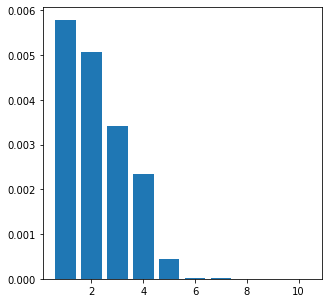

In [137]:
if config["lda-reduce"] != False:
    import lda
    reducer = lda.reducer(X_trn_std_sel,y_trn,config["lda-reduce"],scree_plot=True)

    X_trn_std_sel_red = reducer.transform(X_trn_std_sel)
    X_vld_std_sel_red = reducer.transform(X_vld_std_sel)
    X_tst_std_sel_red = reducer.transform(X_tst_std_sel)
else:
    X_trn_std_sel_red = X_trn_std_sel
    X_vld_std_sel_red = X_vld_std_sel
    X_tst_std_sel_red = X_tst_std_sel


In [138]:
if config["classifier"] == "qda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    clf = qda.fit(X_trn_std_sel_red,y_trn)
    
elif config["classifier"] == "lda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.LinearDiscriminantAnalysis()
    clf = qda.fit(X_trn_std_sel_red,y_trn)
    
elif config["classifier"] == "lda_self":
    import lda
    clf = lda.classifier(X_trn_std_sel_red,y_trn)

elif config["classifier"] == "svm":
    from sklearn import svm
    clf = svm.SVC( C=1000, decision_function_shape="ovo", gamma=.01 )
    clf.fit(X_trn_std_sel_red,y_trn)

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'train set : Accuracy 73.0%'}, xlabel='Predicted class', ylabel='True class'>)

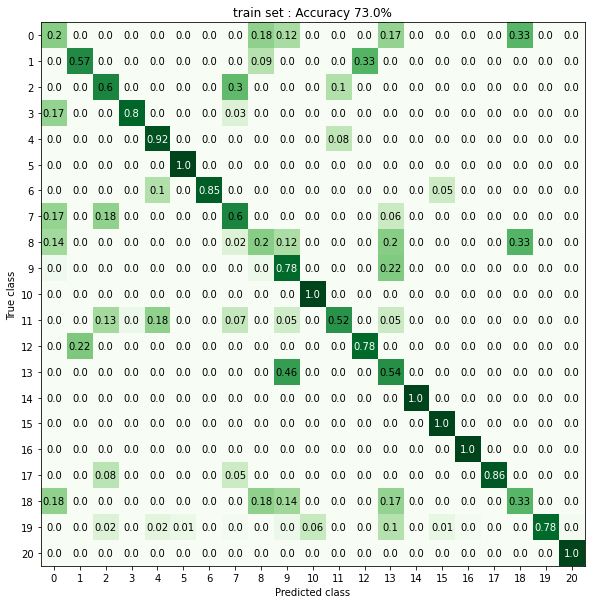

In [139]:
confusion_matrix( cf(y_trn,clf.predict(X_trn_std_sel_red)), figsize = (10,10),title='train set')

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'validation set : Accuracy 72.687%'}, xlabel='Predicted class', ylabel='True class'>)

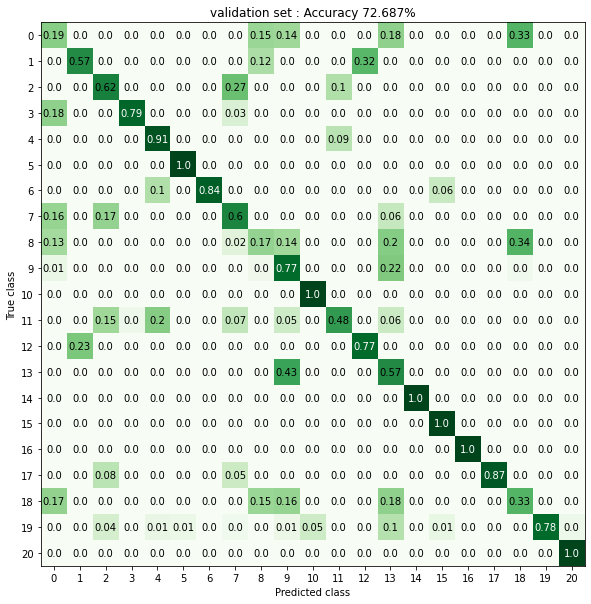

In [140]:
confusion_matrix( cf(y_vld,clf.predict(X_vld_std_sel_red)), figsize = (10,10),title='validation set')

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'test set : Accuracy 66.667%'}, xlabel='Predicted class', ylabel='True class'>)

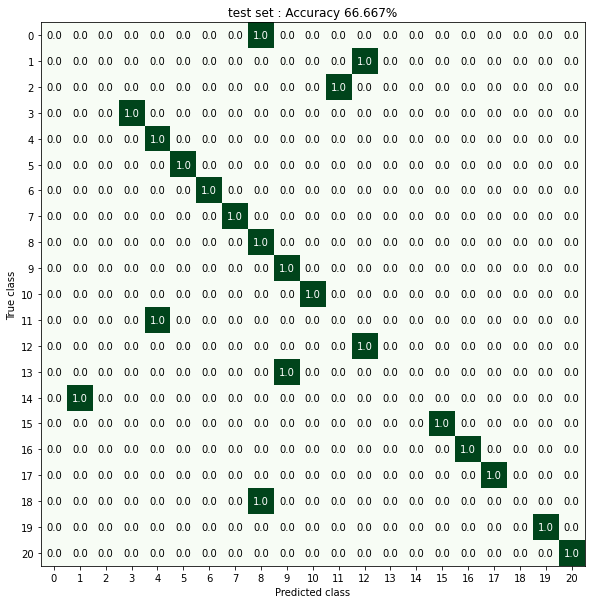

In [141]:
confusion_matrix( cf(y_tst,clf.predict(X_tst_std_sel_red)), figsize = (10,10),title='test set')